# The $\beta$-coeffcient of an Investment

This notebook aims to explore the idea of the $\beta$-coefficient of an investment. Firstly, to offer up an initial caveat: I am not an economist, nor am I a financial expert. In fact, my interest in the stock market only began because the stock market crash caused by the Covid-19 pandemic offered up an opportunity for people who had some spare cash to explore this space a little more. I am very much a beginner in this area, and as someone who's degree program was in mathematics and physics, it is through this lens that I approach $\beta$.

## What is $\beta$?

 Given some asset, and some market index as a benchmark, we can calculate the return of the asset over some time period (denoted by $r_a$) and the return of the benchmark (denoted by $r_b$), and say that these two should be related in some way - the return of the asset should in essence correlate to the return of the benchmark. We assume that this correlation is linear.

$$
r_a = \alpha + \beta r_b + \varepsilon
$$

where $\varepsilon$ is some return of unknown origin or more commonly known as the error.

So we can essentially plot $r_a$ against $r_b$ and find the best fit line using least squares. This will also yield a value for $\beta$. It can shown (presumably through some sort of wizardry) that

$$
\beta = \frac{\text{Cov}(r_a, r_b)}{\text{Var}(r_b)} = \frac{\sigma_{r_a r_b}}{\sigma_{r_b}^2}
$$

The covariance is essentially a measure of how closely related the values of two variables are. For example, if I have large (small) values of one variable corresponding to large (small) values of another variable, then we have a positive covariance. The covariance is negative when large (small) values of one variable correspond to small (large) values of another variable. The covariance is closely related to the correlation, in that the correlation is the normalized covariance to the interval $[-1, 1]$.

$$
\text{Corr}(r_a, r_b) = \rho_{r_a r_b} = \frac{\sigma_{r_a r_b}}{\sigma_{r_a}\sigma_{r_b}}
$$

Hence,

$$
\beta = \rho_{r_ar_b}\frac{\sigma_{r_a}}{\sigma_{r_b}}
$$

The term $\frac{\sigma_{r_a}}{\sigma_{r_b}}$ can be interpreted as how volatile the asset return is compared to the benchmark return. Therefore, if the asset return is exactly as volatile as the benchmark return, then $\frac{\sigma_{r_a}}{\sigma_{r_b}} = 1$. If this value is greater than 1, then the asset is *more* volatile than the benchmark and if less than 1, then the asset is *less* volatile than the benchmark. But there is also this correlation scaling factor which confounds things - if $\frac{\sigma_{r_a}}{\sigma_{r_b}} = 1$ then $\beta <= 1$. But the standard definition of $\beta$ as given by Sharpe is

<blockquote><i>“Stocks with betas greater than one are more volatile than the market and are known as aggressive stocks. In contrast, stocks with betas less than one are less volatile than the market index and are known as defensive stocks”</blockquote>
    
But if the two stocks are poorly correlated, but the asset is highly volatile relative to the benchmark, it is in fact possible to have a low $\beta$!

Therefore, it could useful to also look at the correlations between the asset return and benchmark return. But this is not the only problem. In this notebook we will look at the $\beta$ of a stock and find that it is highly dependent upon both the sampling period and the total length of time sampled over.

## Import Statments

In [1]:
# Ignore a deprecation warning thrown by importing pandas
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import datetime as datetime          # Keep track of time
import matplotlib.pyplot as plt      # Plotting
from matplotlib import style         # Nice plots
import numpy as np                   # Trusty numpy
import pandas as pd                  # Dataframe
import pandas_datareader.data as web # Way to get data
from scipy import stats
import scipy.optimize as opt

# Adjust figure size and make it look pretty.
plt.rcParams['figure.figsize'] = [15, 9]
style.use('ggplot')

# For displaying LaTeX in output
from IPython.display import display, Math

## Pulling and plotting data

Start off by picking our start and end dates. Here we will look only up until the present day, after the crash. Next we load all the finance data from the Yahoo Finance API. To start off with, we will look at Kathmandu, Ltd., which has ticker code: KMD.NZ

In [2]:
start = '01/01/2015' # Start date
end = ''             # End date - just to today is fine
interval = 'd'       # sampling interval, 'd', 'w', 'm'.
ticker_code = 'KMD.NZ'
code = web.get_data_yahoo(ticker_code, start, interval=interval)
code.tail() # look at the bottom of the table - the most recent data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-07,0.70,0.61,0.69,0.62,5340721.0,0.62
2020-04-08,0.67,0.63,0.63,0.64,12326591.0,0.64
2020-04-13,0.71,0.66,0.67,0.69,7166697.0,0.69
2020-04-14,0.87,0.71,0.71,0.77,6720763.0,0.77
2020-04-16,0.85,0.75,0.81,0.77,5536484.0,0.77


Nice. So this is looking good, we have a number of columns, but we care about 'Adj Close'. So let's plot this and see what it looks like. Fortunately, it's easy to produce high quality plots with Pandas

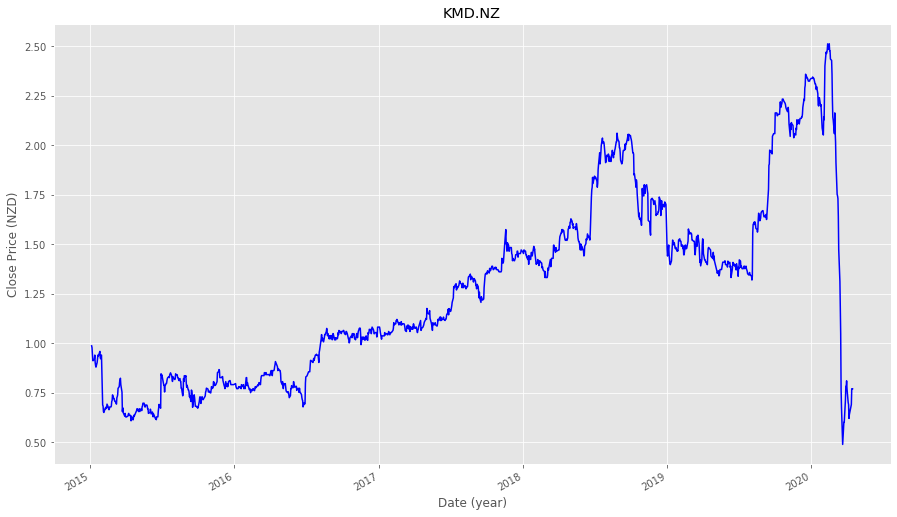

In [3]:
code['Adj Close'].plot(color='blue')
# Give it a title and axis labels, we're not barbarians:
plt.title(ticker_code)
plt.xlabel("Date (year)")
plt.ylabel("Close Price (NZD)")
plt.show()

Well that was easy! Look at that big old dip caused by Covid...nasty. It's easy to have a quick look at the Yahoo Finance site and check that the code.NZ ticker does indeed match out plot above (which it does). Now let's grab the S&P/NZX50 market data...

In [4]:
NZX50 = web.get_data_yahoo('^NZ50', start, interval=interval)
NZX50.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-04-07,10059.929688,10006.669922,10031.660156,10054.360352,4658200.0,10054.360352
2020-04-08,10120.889648,9953.040039,10031.660156,9963.900391,94993700.0,9963.900391
2020-04-13,10444.360352,10159.019531,10159.019531,10443.490234,6493000.0,10443.490234
2020-04-14,10443.559570,10401.459961,10409.940430,10431.639648,3754900.0,10431.639648
2020-04-16,10558.690430,10401.459961,10409.940430,10526.230469,0.0,10526.230469


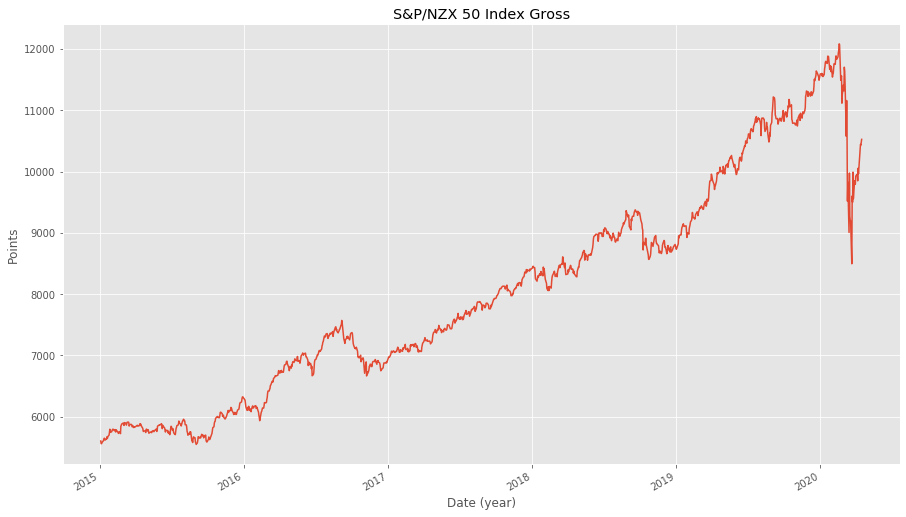

In [5]:
NZX50['Adj Close'].plot()
plt.title("S&P/NZX 50 Index Gross")
plt.xlabel("Date (year)")
plt.ylabel("Points")
plt.show()

It would be useful to be able to plot these on the same graph for a direct comparison, but at the moment both these plots have a different y-scale. One thing we can try is to "normalize" our data. The way we do this is by looking at percentage changes. So we essentially start at the first entry and call it 0% change. Then we look at the second entry and say, "What is the percentage change from the first entry to this entry?" And so on, until we finish. Over time, we should see the overall percentage change.

This should also enable us to plot both sets of data on the same y-axis. We want to keep the original adjusted close price intact, so we can just create a new column in the data frame.

In [6]:
# For some data, the NZX50 is a different length to the ticker data,
# so we go through and check to see if all the dates match up. If not,
# then we drop that row out of the dataframe.

indices_NZX50 = NZX50.index
indices_code = code.index

i = 0
for index in indices_NZX50:
    if index not in indices_code:
        NZX50.drop([index], inplace=True)
        
i = 0
for index in indices_code:
    if index not in indices_NZX50:
        code.drop([index], inplace=True)

In [7]:
# First grab the 'Adj Close' column
code_adj_close = code['Adj Close']
ref = code_adj_close[0]
# Convert to percentage change, can also be written:
# norm_code_adj_close = 100*(code_adj_close/ref - 1)
norm_code_adj_close = 100*((code_adj_close - ref)/ref)
code['Norm Adj Close'] = norm_code_adj_close
code.tail()

,High,Low,Open,Close,Volume,Adj Close,Norm Adj Close
Date,,,,,,,
2020-04-07,0.70,0.61,0.69,0.62,5340721.0,0.62,-37.175878
2020-04-08,0.67,0.63,0.63,0.64,12326591.0,0.64,-35.149296
2020-04-13,0.71,0.66,0.67,0.69,7166697.0,0.69,-30.082833
2020-04-14,0.87,0.71,0.71,0.77,6720763.0,0.77,-21.976497
2020-04-16,0.85,0.75,0.81,0.77,5536484.0,0.77,-21.976497


So now there is a new column with the percentage price change. We do the same for the S&P/NZX50 data,

In [8]:
# First grab the 'Adj Close' column
NZX50_adj_close = NZX50['Adj Close']
ref = NZX50_adj_close[0]
norm_NZX50_adj_close = 100*((NZX50_adj_close - ref)/ref)
NZX50['Norm Adj Close'] = norm_NZX50_adj_close
NZX50.tail()

,High,Low,Open,Close,Volume,Adj Close,Norm Adj Close
Date,,,,,,,
2020-04-07,10059.929688,10006.669922,10031.660156,10054.360352,4658200.0,10054.360352,79.458826
2020-04-08,10120.889648,9953.040039,10031.660156,9963.900391,94993700.0,9963.900391,77.844219
2020-04-13,10444.360352,10159.019531,10159.019531,10443.490234,6493000.0,10443.490234,86.404349
2020-04-14,10443.559570,10401.459961,10409.940430,10431.639648,3754900.0,10431.639648,86.192830
2020-04-16,10558.690430,10401.459961,10409.940430,10526.230469,0.0,10526.230469,87.881167


Hopefully we should now be able to plot the same data on one graph.

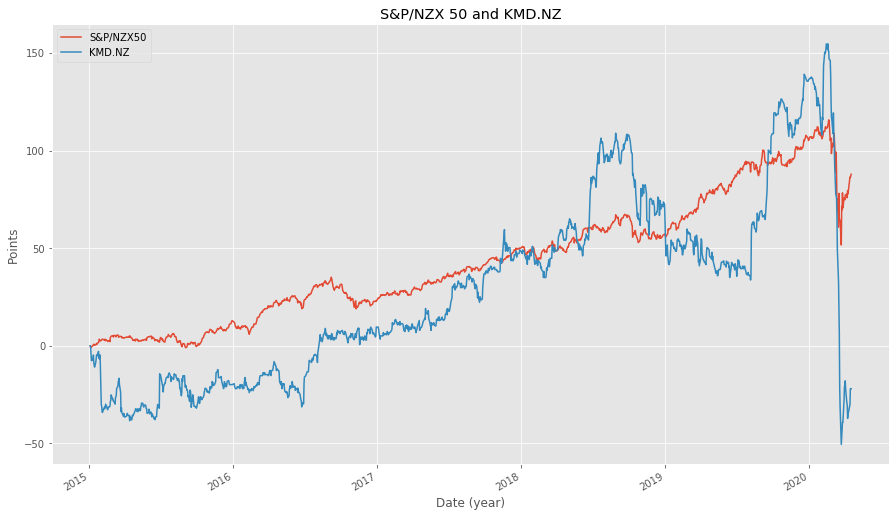

In [9]:
plt.figure()
NZX50['Norm Adj Close'].plot(label='S&P/NZX50')
code['Norm Adj Close'].plot(label=ticker_code)
plt.title("S&P/NZX 50 and " + ticker_code)
plt.xlabel("Date (year)")
plt.ylabel("Points")
plt.legend()
plt.show()

We'll add some nice little things to make stuff look cool.

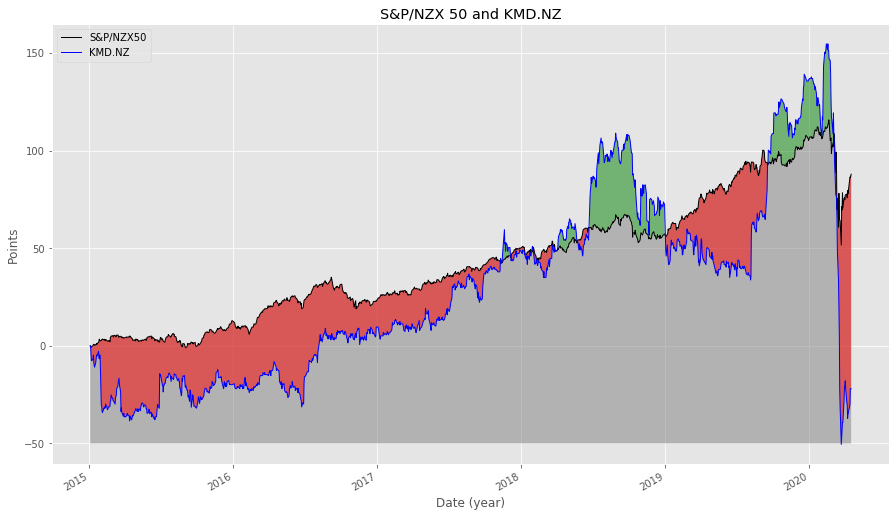

In [10]:
plt.figure()
y1 = NZX50['Norm Adj Close']
y2 = code['Norm Adj Close']
y1.plot(color='black', label='S&P/NZX50', lw=1)
y2.plot(color='blue', label=ticker_code, lw=1)
# If the code percentage change is higher than the benchmark, we fill
# everything in green. If the code percentage change is lower than the
# benchmark, fill in red. Fill everything below the benchmark in grey.
# Just because.
plt.fill_between(y1.index, y1.values, -50, facecolor='grey', alpha=0.5)
plt.fill_between(y1.index, y2.values, y1.values, where=y2.values>=y1.values, facecolor='green', alpha=0.5)
plt.fill_between(y1.index, y2.values, y1.values, where=y2.values<=y1.values, facecolor='red', alpha=0.5)
plt.title("S&P/NZX 50 and " + ticker_code)
plt.xlabel("Date (year)")
plt.ylabel("Points")
plt.legend()
plt.show()

## Beta

The first thing we can do is plot $r_b$ on the $x$-axis and $r_a$ on the $y$-axis. We need to create a new column in our dataframe which will compare each daily price with the closing price of the previous day, and work out the percentage change from one day to the next. As a bit more practice, we'll do this independently of our previously created percentage column, but there is a faster way to do this, and we'll look at it later.

In [11]:
# First grab the 'Adj Close' column of the code
period = 1
code_adj_close = code['Adj Close'].values
code_returns = np.zeros((len(code),))
i = 0
previous = code_adj_close[0]
while i < len(code_returns):
    code_returns[i] = (code_adj_close[i]/previous) - 1
    previous = code_adj_close[i]
    i += 1
#code['Returns'] = code_returns

# Now grab the 'Adj Close' column of the NZX50
NZX50_adj_close = NZX50['Adj Close'].values
NZX50_returns = np.zeros((len(NZX50),))
i = 0
previous = NZX50_adj_close[0]
while i < len(NZX50_returns):
    NZX50_returns[i] = (NZX50_adj_close[i]/previous) - 1
    previous = NZX50_adj_close[i]
    i += 1
#NZX50['Returns'] = NZX50_returns

We only really want this data to do plotting, so we can keep it seperate or add it to the dataframe (uncomment out lines `#code['Returns'] = code_returns` and `#NZX50['Returns'] = NZX50_returns` in order to add this data to the dataframes). I'll just stack the two columns of data on top of one another, and then get rid of the zeros at the start, because these aren't really useful to us and could skew the fit line.

In [12]:
X = 100*np.stack((NZX50_returns, code_returns))
X = X[:,1:]

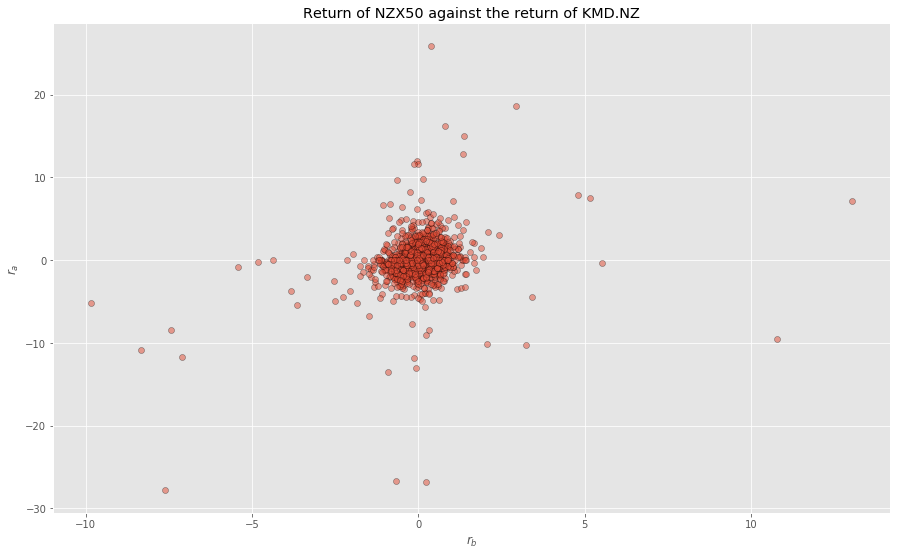

In [13]:
# Now we plot our returns against one another.
plt.scatter(X[0,:], X[1,:], edgecolors='k', alpha=0.5)
plt.xlabel(r'$r_b$')
plt.ylabel(r'$r_a$')
plt.title("Return of NZX50 against the return of " + ticker_code)
plt.show()

So everything is clumped around $(0,0)$. Things don't look particularly correlated either. We can find the correlation coefficient between $r_a$ and $r_b$ by using `np.corrcoef()`.

In [14]:
corr_coef = np.corrcoef(X[0,:], X[1,:])
print(round(corr_coef[1,0],2))

0.27


So the volatilities of the code and then benchmark are not particularly correlated as expected by looking at the plot. Now that we've got everything we need lets look at trying to find the $\beta$ of Kathmandu, where

$$
\beta = \frac{Cov(r_{a}, r_{b})}{Var(r_{b})}
$$

and $r_{a}$ is the return of Kathmandu, and $r_{b}$ is the return of the market index.

This is actually super easy. We can just use `np.cov()` which gives us a covariance matrix. The diagonal entries give the variance of the variables, and the off diagonals give the covariance between them.

In [15]:
covar = np.cov(X)
display(Math(r'$$ \beta = {:.3f}$$'.format(covar[0,1]/covar[0,0])))

<IPython.core.display.Math object>

So this gives us our $\beta$. Since $\beta < 1$, we would conclude that KMD is less volatile than the bench mark. But if we refer to our introductory ramble, we know that the term $\frac{\sigma_{r_a}}{\sigma_{r_b}}$ can be interpreted as how volatile the asset return is compared to the benchmark return. So let's work this out.

In [16]:
volatility = np.sqrt(covar[1,1])/np.sqrt(covar[0,0])
print(round(volatility,2))

2.81


As a sanity check, we should be able to do $\beta = \rho_{r_ar_b}\frac{\sigma_{r_a}}{\sigma_{r_b}}$.

In [17]:
display(Math(r'$$ \beta = {:.3f}$$'.format(round(corr_coef[1,0] * volatility, 3))))

<IPython.core.display.Math object>

Good, so that worked as expected. But let's look at what's happened here: we got a low value for $\beta$ suggesting that the stock return is less volatile than the benchmark, but clearly the relative volatility is much greater than one, and this low $\beta$ is simply because the actual volatility is masked by a low correlation.

Now let's plot all of our data, and find the fit line using `scipy.optimize.curve_fit()`. This will also serve as a further reality check that our $\beta$ is reasonable.

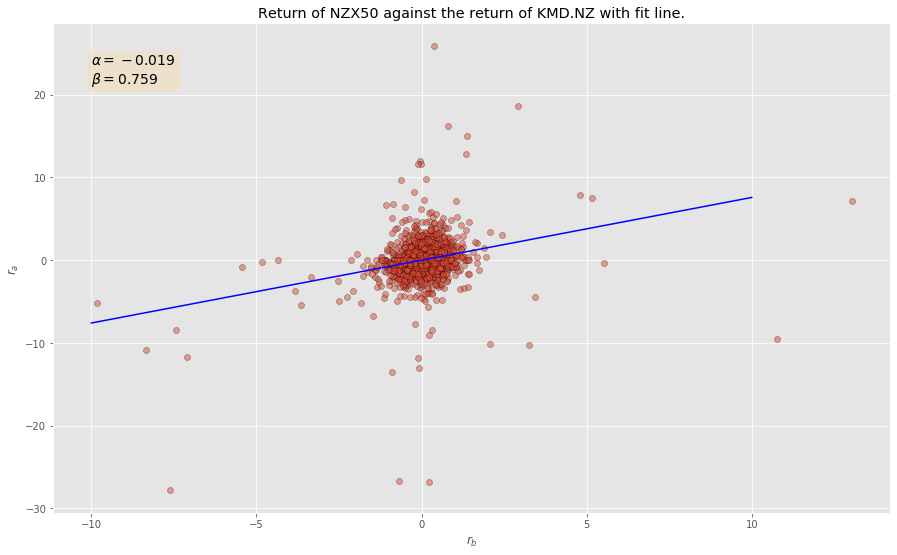

In [18]:
import scipy.optimize as opt

def model(x, a, b):
    """Linear fit."""
    y = a*x + b
    return y

coeffs_V, covar_V = opt.curve_fit(f=model, xdata=X[0,:], ydata=X[1,:])

x = np.linspace(-10, 10, 1000)
y = model(x, coeffs_V[0], coeffs_V[1])

textstr = '\n'.join((
    r'$\alpha=%.3f$' % (coeffs_V[1], ),
    r'$\beta=%.3f$' % (coeffs_V[0], )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.scatter(X[0,:], X[1,:], edgecolors='k', alpha=0.5)
plt.plot(x, y, 'blue')
plt.text(-10, 25, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
plt.xlabel(r'$r_b$')
plt.ylabel(r'$r_a$')
plt.title("Return of NZX50 against the return of " + ticker_code + " with fit line.")
plt.show()

## Trying with another stock

Although this is the best fit line according to least squares, it seems like it could really go any which way! Let's try with another stock. Since we want to play around with a bunch of different ticker codes, and we want to make the interval variable, we write some functions that return the important stuff. I mentioned that there was a faster way to get the fit line, so I'll now use that.

In [19]:
def model(x, a, b):
    """Linear fit."""
    y = a*x + b
    return y

def get_dataframes(start, ticker_code, end='', interval='d'):
    """
    Goes onto Yahoo! Finance and pulls the necessary dataframes.
    """
    code = web.get_data_yahoo(ticker_code, start, interval=interval)
    NZX50 = web.get_data_yahoo('^NZ50', start, interval=interval)

    # Again, we go through and filter out the non-intersecting dates
    indices_NZX50 = NZX50.index
    indices_code = code.index

    i = 0
    for index in indices_NZX50:
        if index not in indices_code:
            NZX50.drop([index], inplace=True)

    i = 0
    for index in indices_code:
        if index not in indices_NZX50:
            code.drop([index], inplace=True)

    # First grab the 'Adj Close' column
    code_adj_close = code['Adj Close']
    ref = code_adj_close[0]
    # Convert to percentage change, can also be written:
    # norm_code_adj_close = 100*(code_adj_close/ref - 1)
    norm_code_adj_close = 100*((code_adj_close - ref)/ref)
    code['Norm Adj Close'] = norm_code_adj_close

    NZX50_adj_close = NZX50['Adj Close']
    ref = NZX50_adj_close[0]
    norm_NZX50_adj_close = 100*((NZX50_adj_close - ref)/ref)
    NZX50['Norm Adj Close'] = norm_NZX50_adj_close
    
    return code, NZX50


def get_beta(code, NZX50):
    """
    Get the alpha and beta coefficients as well as the correlation coefficient.
    """
    price_data = code['Adj Close']
    ret_data = 100*price_data.pct_change()[1:]
    bench_price = NZX50['Adj Close']
    bench_ret = 100*bench_price.pct_change()[1:]
    beta, alpha = stats.linregress(bench_ret.values,
                    ret_data.values)[0:2]
    
    X = np.stack((bench_ret, ret_data))
    return X, beta, alpha
    
def plot_comparison(code, NZX50):
    """
    Plots the graphs that compare the asset with the benchmark.
    """
    plt.figure()
    y1 = NZX50['Norm Adj Close']
    y2 = code['Norm Adj Close']
    y1.plot(color='black', label='S&P/NZX50', lw=1)
    y2.plot(color='blue', label=ticker_code, lw=1)
    # If the code percentage change is higher than the benchmark, we fill
    # everything in green. If the code percentage change is lower than the
    # benchmark, fill in red. Fill everything below the benchmark in grey.
    # Just because.
    plt.fill_between(y1.index, y1.values, -50, facecolor='grey', alpha=0.5)
    plt.fill_between(y1.index, y2.values, y1.values, where=y2.values>=y1.values, facecolor='green', alpha=0.5)
    plt.fill_between(y1.index, y2.values, y1.values, where=y2.values<=y1.values, facecolor='red', alpha=0.5)
    plt.title("S&P/NZX 50 and " + ticker_code)
    plt.xlabel("Date (year)")
    plt.ylabel("Points")
    plt.legend()
    plt.show()
    
def plot_fit(X, alpha, beta, corr_coef, vol):
    """
    Plot fit line.
    """
    x = np.linspace(min(X[0,:]), max(X[0,:]), 1000)
    y = model(x, beta, alpha)

    textstr = '\n'.join((
        r'$\alpha=%.3f$' % (alpha, ),
        r'$\beta=%.3f$' % (beta, ),
        r'$Corr=%.3f$' % (corr_coef, ),
        r'$Volatility=%.3f$' % (vol, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.scatter(X[0,:], X[1,:], edgecolors='k', alpha=0.5)
    plt.plot(x, y, 'blue')
    plt.text(min(X[0,:]), max(X[1,:]), textstr, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.xlabel(r'$r_b$')
    plt.ylabel(r'$r_a$')
    plt.title("Return of NZX50 against the return of " + ticker_code + " with fit line.")
    plt.show()

### Freightways

Now let's have a look at Freightways, Ltd.

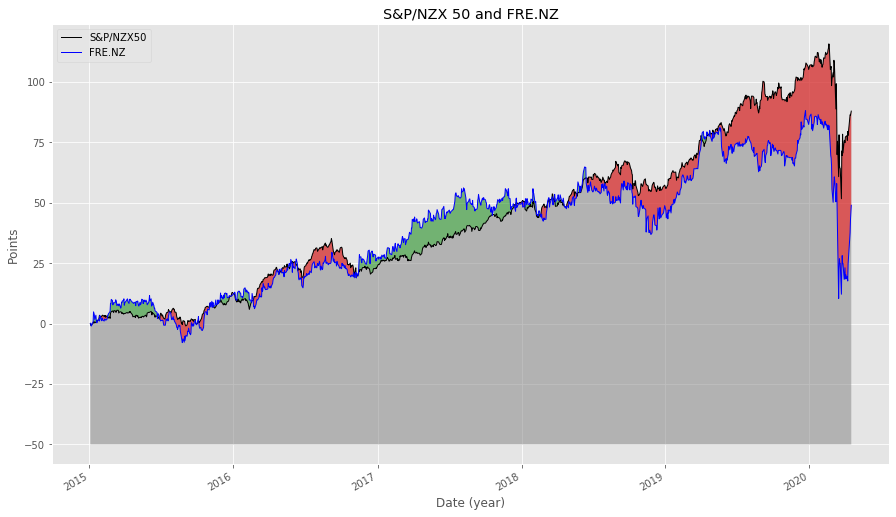

In [20]:
start = '01/01/2015' # Start date
end = ''             # End date - just to today is fine
interval = 'd'       # sampling interval, 'd', 'w', 'm'.
ticker_code = 'FRE.NZ'

code, NZX50 = get_dataframes(start, ticker_code, end='', interval='d')
plot_comparison(code, NZX50)

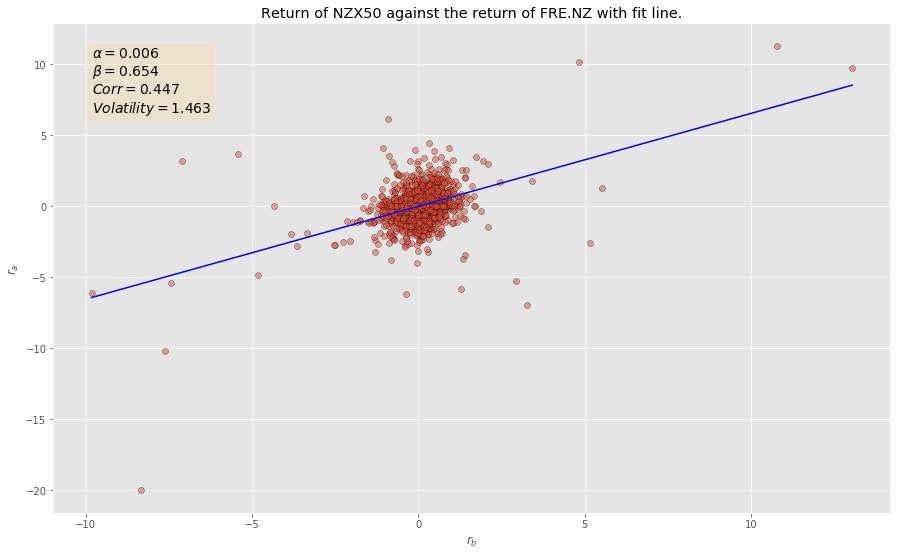

In [21]:
X, beta, alpha = get_beta(code, NZX50)
covar = np.cov(X)
corr_coef = np.corrcoef(X)
vol = np.sqrt(covar[1,1])/np.sqrt(covar[0,0])

plot_fit(X, alpha, beta, corr_coef[0,1], vol)

So we have the same situation with Freightways. Now let's have a look at Kathmandu again, but this time, we'll increase the sample interval to one week.

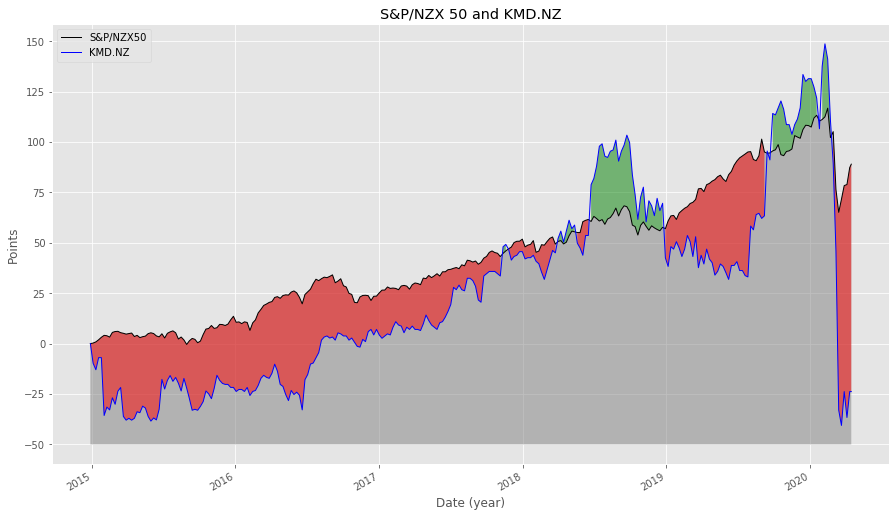

In [22]:
start = '01/01/2015' # Start date
end = ''             # End date - just to today is fine
interval = 'w'       # sampling interval, 'd', 'w', 'm'.
ticker_code = 'KMD.NZ'

code, NZX50 = get_dataframes(start, ticker_code, end='', interval=interval)
plot_comparison(code, NZX50)

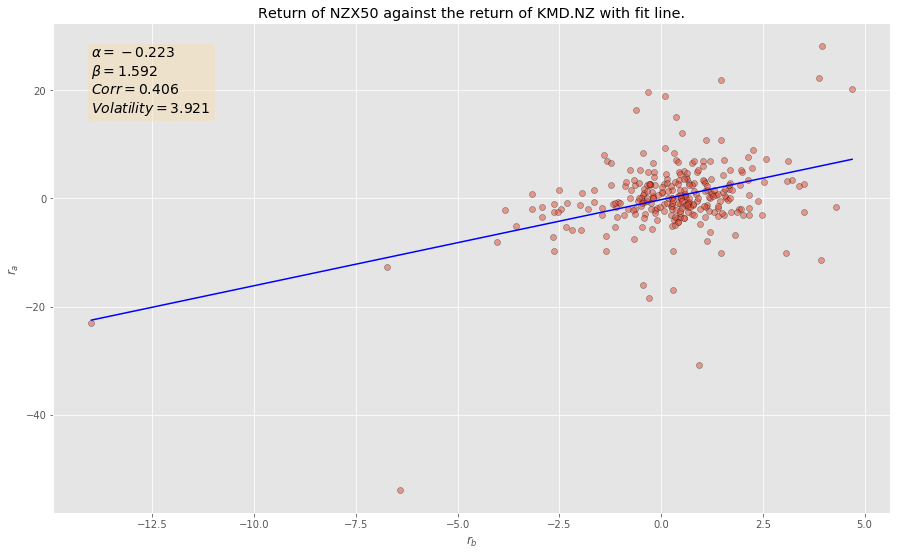

In [23]:
X, beta, alpha = get_beta(code, NZX50)
covar = np.cov(X)
corr_coef = np.corrcoef(X)
vol = np.sqrt(covar[1,1])/np.sqrt(covar[0,0])

plot_fit(X, alpha, beta, corr_coef[0,1], vol)

So now, notice first of call that our value for $\beta$ has increased and now this is telling us that KMD is more volatile than the benchmark. But just look at the correlation! We can even see from the plot that the stock return is barely correlated to the bench return. Things don't really improve if we increase this interval to one month either. Next, we will try and look at many different stocks and see if there is some sort of systematic relationship going on between $\beta$ and sampling intervals **(Coming Soon...)**.